In [1]:
import math
import torch
from torch import Tensor

# GMM implementation from scratch
### GMM class definition
    - n_components: number of mixture components
    - max_iter: max EM iterations
    - tol: convergence tolerance on log likelihood improvement
    - reg_covar: added to diagonal of covariance matrices for numeric stability
    - init_params: 'kmeans' or 'random'
    - fitted parameters: weights_, means_, covariances_
### methods
    - _init_params
    - _estimate_log_gaussian_prob (P(x|\mu_k,\Sigma_k)
    - _e_step
    - _m_step
    - fit (alternate e-step and m-step until convergence)
    - predict_proba (compute responsibilities)
    - predict (hard cluster assignment)
    - sample (from a fitted mixture)

In [2]:
class GMM:
    """
    Gaussian Mixture Model (EM) with full covariance matrices, implemented in PyTorch.
    - n_components: number of mixture components
    - max_iter: max EM iterations
    - tol: convergence tolerance on log likelihood improvement
    - reg_covar: added to diagonal of covariance matrices for numeric stability
    - init_params: 'kmeans' or 'random'
    """

    def __init__(self, n_components=3, max_iter=200, tol=1e-4, reg_covar=1e-6, init_params='kmeans', device=None, dtype=torch.float32):
        self.n_components = int(n_components)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.reg_covar = float(reg_covar)
        assert init_params in ('kmeans', 'random')
        self.init_params = init_params
        self.device = device or torch.device('cpu')
        self.dtype = dtype

        # fitted parameters (will be set in fit)
        self.weights_ = None    # (K,)
        self.means_ = None      # (K, D)
        self.covariances_ = None # (K, D, D)

    def _check_X(self, X):
        if not torch.is_tensor(X):
            X = torch.tensor(X, dtype=self.dtype, device=self.device)
        else:
            X = X.to(device=self.device, dtype=self.dtype)
        assert X.dim() == 2, "X should be 2D (N, D)"
        return X

    # ----- initialization (kmeans-like) -----
    def _init_params(self, X):
        N, D = X.shape
        K = self.n_components

        if self.init_params == 'random':
            # random pick means from data
            ids = torch.randperm(N, device=self.device)[:K]
            means = X[ids].clone()
        else:
            # simple kmeans++ initialization (not full kmeans iterations, but good seeds)
            means = torch.empty((K, D), dtype=self.dtype, device=self.device)
            ids = torch.randperm(N, device=self.device)
            means[0] = X[ids[0]]
            # distances for each point to nearest center
            dist = torch.full((N,), float('inf'), device=self.device, dtype=self.dtype)
            for k in range(1, K):
                d = torch.sum((X - means[k-1])**2, dim=1)
                dist = torch.minimum(dist, d)
                # probability proportional to dist
                probs = dist / torch.sum(dist)
                # sample next center
                idx = torch.multinomial(probs, 1).item()
                means[k] = X[idx]

        # initial covariances: empirical covariance of X plus reg, assign identical to all
        emp_cov = self._empirical_covariance(X, X.mean(dim=0))
        covariances = emp_cov.unsqueeze(0).repeat(K, 1, 1)  # (K, D, D)
        covariances += torch.eye(D, device=self.device, dtype=self.dtype).unsqueeze(0) * self.reg_covar

        weights = torch.full((K,), 1.0 / K, dtype=self.dtype, device=self.device)
        self.means_ = means
        self.covariances_ = covariances
        self.weights_ = weights

    @staticmethod
    def _empirical_covariance(X, mean):
        # unbiased estimator / N (we'll use ML estimator dividing by N)
        Xc = X - mean
        cov = (Xc.t() @ Xc) / X.shape[0]
        return cov

    # ----- logpdf computation (stable) -----
    def _estimate_log_gaussian_prob(self, X):
        """
        Compute log N(x | mu_k, Sigma_k) for all k and x.
        Returns shape (N, K)
        Uses Cholesky-based stable computation of logpdf.
        """
        N, D = X.shape
        K = self.n_components
        log_probs = torch.empty((N, K), dtype=self.dtype, device=self.device)

        for k in range(K):
            mu = self.means_[k]               # (D,)
            cov = self.covariances_[k]        # (D, D)
            # ensure symmetric and add reg_covar
            cov = (cov + cov.t()) / 2.0
            cov = cov + torch.eye(D, device=self.device, dtype=self.dtype) * self.reg_covar

            # Cholesky decomposition of cov: cov = L L^T
            try:
                L = torch.linalg.cholesky(cov)  # lower-triangular
            except RuntimeError as e:
                # fallback: add more regularization if cholesky fails
                jitter = self.reg_covar * 10
                L = torch.linalg.cholesky(cov + torch.eye(D, device=self.device, dtype=self.dtype) * jitter)

            # compute log |cov| = 2 * sum(log(diag(L)))
            log_det = 2.0 * torch.sum(torch.log(torch.diagonal(L)))
            # solve for y = L^{-1} (x - mu)
            xm = X - mu.unsqueeze(0)  # (N, D)
            # solve triangular system: for each row
            # use torch.triangular_solve or torch.linalg.solve (more modern)
            # solve L y = xm^T  => y = L^{-1} xm^T
            y = torch.linalg.solve(L, xm.t())  # (D, N)
            quad = torch.sum(y**2, dim=0)      # (N,)
            # log gaussian
            const = -0.5 * (D * math.log(2 * math.pi))
            log_probs[:, k] = const - 0.5 * log_det - 0.5 * quad
        return log_probs  # (N, K)

    # ----- E-step: responsibilities and log likelihood -----
    def _e_step(self, X):
        """
        Returns:
          - log_resp: (N, K) log responsibilities
          - resp: (N, K) responsibilities
          - log_likelihood: scalar
        """
        N, D = X.shape
        log_gauss = self._estimate_log_gaussian_prob(X)  # (N, K)
        log_weights = torch.log(self.weights_.clamp(min=1e-30))  # (K,)
        log_prob = log_gauss + log_weights.unsqueeze(0)  # (N, K)

        # log-sum-exp over components to get per-sample normalizer
        max_log = torch.max(log_prob, dim=1, keepdim=True).values  # (N,1)
        lse = max_log + torch.log(torch.sum(torch.exp(log_prob - max_log), dim=1, keepdim=True))  # (N,1)
        log_resp = log_prob - lse  # normalized log responsibilities (N,K)
        resp = torch.exp(log_resp)

        # total log-likelihood is sum of lse
        log_likelihood = torch.sum(lse).item()
        return log_resp, resp, log_likelihood

    # ----- M-step: update params given responsibilities -----
    def _m_step(self, X, resp):
        N, D = X.shape
        K = self.n_components

        # effective number of points per component
        nk = resp.sum(dim=0) + 1e-10  # (K,)
        weights = nk / N              # (K,)

        # update means
        means = (resp.t() @ X) / nk.unsqueeze(1)  # (K, D)

        # update covariances
        covariances = torch.empty((K, D, D), dtype=self.dtype, device=self.device)
        for k in range(K):
            Xm = X - means[k].unsqueeze(0)  # (N, D)
            # weighted covariance (ML estimator dividing by nk[k])
            wk = resp[:, k].unsqueeze(1)  # (N, 1)
            cov = (Xm * wk).t() @ Xm / nk[k]
            # symmetric and regularize
            cov = (cov + cov.t()) / 2.0
            cov += torch.eye(D, device=self.device, dtype=self.dtype) * self.reg_covar
            covariances[k] = cov

        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covariances

    # ----- main fit -----
    def fit(self, X, verbose=False):
        """
        Fit the GMM to X using EM.
        X: array-like (N, D) or torch tensor
        """
        X = self._check_X(X)
        N, D = X.shape
        self._init_params(X)

        prev_log_likelihood = -float('inf')
        for i in range(self.max_iter):
            log_resp, resp, log_likelihood = self._e_step(X)
            self._m_step(X, resp)
            improvement = log_likelihood - prev_log_likelihood
            if verbose:
                print(f"Iter {i:3d}  log-likelihood: {log_likelihood:.6f}  improvement: {improvement:.6f}")
            if abs(improvement) < self.tol:
                break
            prev_log_likelihood = log_likelihood
        return self

    # ----- responsibilities and predictions -----
    def predict_proba(self, X):
        X = self._check_X(X)
        log_gauss = self._estimate_log_gaussian_prob(X)
        log_weights = torch.log(self.weights_.clamp(min=1e-30))
        log_prob = log_gauss + log_weights.unsqueeze(0)
        # normalise
        max_log = torch.max(log_prob, dim=1, keepdim=True).values
        lse = max_log + torch.log(torch.sum(torch.exp(log_prob - max_log), dim=1, keepdim=True))
        log_resp = log_prob - lse
        return torch.exp(log_resp)  # (N, K)

    def score_samples(self, X):
        """Return per-sample log-likelihoods (log p(x))."""
        X = self._check_X(X)
        log_gauss = self._estimate_log_gaussian_prob(X)
        log_weights = torch.log(self.weights_.clamp(min=1e-30))
        log_prob = log_gauss + log_weights.unsqueeze(0)
        # log-sum-exp across components
        max_log = torch.max(log_prob, dim=1, keepdim=True).values
        lse = max_log + torch.log(torch.sum(torch.exp(log_prob - max_log), dim=1, keepdim=True))
        return lse.squeeze(1)  # (N,)

    def predict(self, X):
        """Return component labels (hard assignment)"""
        proba = self.predict_proba(X)
        return torch.argmax(proba, dim=1)

    # ----- sampling from fitted mixture -----
    def sample(self, n_samples=1):
        if self.weights_ is None:
            raise ValueError("Model not fitted yet")
        K, D = self.means_.shape
        # choose components
        comp_idx = torch.multinomial(self.weights_, n_samples, replacement=True)
        samples = torch.empty((n_samples, D), dtype=self.dtype, device=self.device)
        for i in range(n_samples):
            k = comp_idx[i].item()
            mu = self.means_[k]
            cov = self.covariances_[k]
            # sample from multivariate normal via cholesky
            L = torch.linalg.cholesky(cov)
            z = torch.randn(D, dtype=self.dtype, device=self.device)
            samples[i] = mu + (L @ z)
        return samples, comp_idx

    # ----- utility: get params as numpy for inspection -----
    def get_params(self):
        return {
            'weights': self.weights_.cpu().numpy(),
            'means': self.means_.cpu().numpy(),
            'covariances': self.covariances_.cpu().numpy()
        }


# Test the GMM implementation

In [3]:
torch.manual_seed(0)

# generate synthetic 2D data: 3 clusters
N = 900
mus = torch.tensor([[0., 0.], [5., 5.], [-5., 4.]])
covs = torch.stack([torch.eye(2)*0.5, torch.tensor([[1.0, 0.3],[0.3, 0.5]]), torch.tensor([[0.7, -0.2],[-0.2, 0.6]])])
weights = torch.tensor([0.3, 0.5, 0.2])

X = []
for k in range(3):
    nk = int(N * weights[k].item())
    L = torch.linalg.cholesky(covs[k])
    z = torch.randn(nk, 2)
    Xk = mus[k] + (z @ L.t())
    X.append(Xk)
X = torch.vstack(X)

# fit GMM
model = GMM(n_components=3, max_iter=200, tol=1e-5, reg_covar=1e-6)
model.fit(X, verbose=True)

print("Fitted weights:", model.weights_)
print("Fitted means:", model.means_)
# check predicted labels
labels = model.predict(X)
print("Counts per predicted cluster:", torch.bincount(labels))


Iter   0  log-likelihood: -4537.926270  improvement: inf
Iter   1  log-likelihood: -3633.663086  improvement: 904.263184
Iter   2  log-likelihood: -3118.472412  improvement: 515.190674
Iter   3  log-likelihood: -3017.172363  improvement: 101.300049
Iter   4  log-likelihood: -3016.497070  improvement: 0.675293
Iter   5  log-likelihood: -3016.479004  improvement: 0.018066
Iter   6  log-likelihood: -3016.477783  improvement: 0.001221
Iter   7  log-likelihood: -3016.477783  improvement: 0.000000
Fitted weights: tensor([0.5006, 0.2994, 0.2000])
Fitted means: tensor([[ 4.9458,  5.0287],
        [ 0.0800,  0.0122],
        [-4.9737,  3.9175]])
Counts per predicted cluster: tensor([451, 269, 180])


# GMMs on MNIST
- Loading MNIST
- Flattening images into 784-dim vectors
-  PCA for dimensionality reduction (GMM in 784 dimensions is very slow)
- Evaluating cluster assignments vs. true MNIST labels
- Visualize cluster means

In [4]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Load MNIST data

In [5]:
def load_mnist():
    transform = transforms.ToTensor()
    train = MNIST(root="./data", train=True, download=True, transform=transform)
    test = MNIST(root="./data", train=False, download=True, transform=transform)
    X_train = train.data.numpy().reshape(-1, 28*28).astype(float)
    X_test = test.data.numpy().reshape(-1, 28*28).astype(float)
    y_train = train.targets.numpy()
    y_test = test.targets.numpy()
    print("Train shape:", X_train.shape)
    print("Test shape:",  X_test.shape)
    return X_train, y_train, X_test, y_test

# Reduce dimensionality via PCA
- PCA to D dimensions (50, initially)

In [6]:
def reduce_dimensionality(X_train, X_test, n_components=50):
    pca = PCA(n_components=n_components, whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("After PCA train set dim:", X_train_pca.shape)
    print("After PCA test set dim:", X_test_pca.shape)
    return X_train_pca, X_test_pca, pca


# Fit the GMM
- use sklearn GaussianMixture

In [7]:
def fit_gmm(X_train_pca, n_components=10,covariance_type='full',tol=1e-6,reg_covar=1e-6,
            max_iter=100,n_init=1,init_params='kmeans',random_state=0):
    gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            tol=tol, reg_covar=reg_covar,
            max_iter=max_iter,n_init=n_init,init_params=init_params,
            random_state=random_state,
            )

    gmm.fit(X_train_pca)
    return gmm

# Visualize cluster means

In [8]:
def visualize_cluster_means(gmm, pca, n_cols=5):
    means_pca = gmm.means_
    means_img = pca.inverse_transform(means_pca).reshape(-1, 28, 28)

    n = means_img.shape[0]
    n_rows = int(np.ceil(n / n_cols))
    plt.figure(figsize=(12, 6))

    for i in range(n):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(means_img[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Cluster {i}")
    plt.tight_layout()
    plt.show()

# Conditional sampling from a GMM

In [9]:
def sample_from_cluster(gmm, pca, cluster_id, n_samples=10):
    mean = gmm.means_[cluster_id]
    cov = gmm.covariances_[cluster_id]
    samples = np.random.multivariate_normal(mean, cov, size=n_samples)
    imgs = pca.inverse_transform(samples).reshape(-1, 28, 28)


    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Samples from GMM cluster {cluster_id}")
    plt.show()

Loading MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.03MB/s]


Train shape: (60000, 784)
Test shape: (10000, 784)
Applying PCA...
After PCA train set dim: (60000, 50)
After PCA test set dim: (10000, 50)
Fitting GMM...


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Predicting clusters...
Visualizing cluster means...


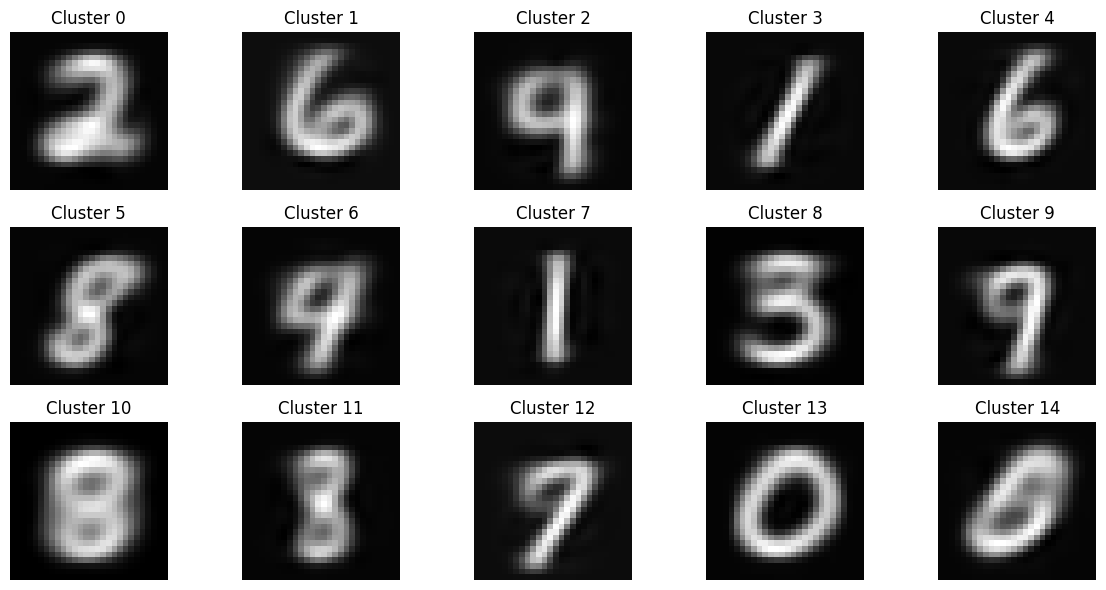

Sampling from cluster 1...


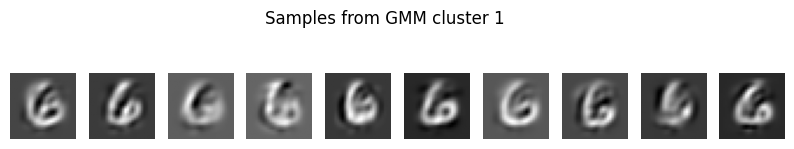

In [10]:
print("Loading MNIST...")
X_train, y_train, X_test, y_test = load_mnist()

print("Applying PCA...")
X_train_pca, X_test_pca, pca = reduce_dimensionality(X_train, X_test)


print("Fitting GMM...")
gmm = fit_gmm(X_train_pca,n_components=15)


print("Predicting clusters...")
clusters_train = gmm.predict(X_train_pca)
clusters_test = gmm.predict(X_test_pca)

print("Visualizing cluster means...")
visualize_cluster_means(gmm, pca)

print("Sampling from cluster 1...")
sample_from_cluster(gmm, pca, cluster_id=1)


# Exploration of Key Hyperparameters & choices for GMM fits

- Pipeline
    - Load MNIST, standardize (zero mean, unit variance).
    - PCA -- choose d (50 or 100). Choose whiten=True. Try both values, and select best.
    - Grid-search GMM: see list of parameters below.
    - Evaluate with BIC/AIC, log_likelihood; inspect cluster means  
    - Once best params found, refit on full training set.
- Grid search parameters
  - n_components in [10,20,30,50,100]
  - covariance_type in ['diag','full','tied']
  - n_init = [5,10,15,20]
  - max_iter = 300
  - tol=1e-4 (monitor log-likelihood; increase max_iter for larger n_components)
  - init_params = kmeans++
  - reg_covar = 1e-6 --- increase if needed to 1e-4 or 1e-3 if you get singular matrix errors

Show your code for finding the best GMM hyperparameters for MNIST and show the loglikelihood achieved, BIC/AIC scores and visualize the cluster means for your best hyperparameters. Leave all your plots/visualizations in place.

- Discuss your results,  interpret the clusters and reflect on EM's behavior as the number of components increases.

# Your code here

In [11]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [12]:
X_train, y_train, X_test, y_test = load_mnist()

Train shape: (60000, 784)
Test shape: (10000, 784)


In [13]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)



In [25]:
X_train_50, X_test_50, pca_50 = reduce_dimensionality(X_train_std, X_test_std, 50)

X_train_100, X_test_100, pca_100 = reduce_dimensionality(X_train_std, X_test_std, 100)

pca_results_train = [X_train_50, X_train_100]
pca_results_test = [X_test_50, X_test_100]

pca_results_train_small = [X_train_50[:2000,:], X_train_100[:2000,:]]
pca = [pca_50, pca_100]

After PCA train set dim: (60000, 50)
After PCA test set dim: (10000, 50)
After PCA train set dim: (60000, 100)
After PCA test set dim: (10000, 100)


In [15]:
pca_dim = [50,100]
n_components = [10,20,30,50,100]
covariance_type = ['diag','full','tied']
n_init = [5,10,15,20]

results = []
best_bic = float('inf')
best_aic = float('inf')
best_params = None
best_model = None

for pca in range(len(pca_dim)):
  for n in n_components:
      for cov in covariance_type:
          for init in n_init:
            X_train_pca = pca_results_train_small[pca]
            gmm = fit_gmm(X_train_pca,n_components=n,covariance_type=cov,n_init=init, tol=1e-4, reg_covar=1e-6, max_iter=300, init_params='k-means++', random_state=0)
            log_likelihood = gmm.score(X_train_pca)
            bic = gmm.bic(X_train_pca)
            aic = gmm.aic(X_train_pca)

            results.append({
                  "pca_index":pca,
                  "pca_dim": pca_dim[pca],
                  "n_components": n,
                  "covariance_types":cov,
                  "n_init":init,
                  "log_likelihood":log_likelihood,
                  "BIC":bic,
                  "AIC":aic})

results_df = pd.DataFrame(results)
display(results_df.head())

,pca_index,pca_dim,n_components,covariance_types,n_init,log_likelihood,BIC,AIC
0,0,50,10,diag,5,-56.228781,232584.435622,226933.125041
1,0,50,10,diag,10,-56.213987,232525.256892,226873.946310
2,0,50,10,diag,15,-56.213987,232525.256892,226873.946310
3,0,50,10,diag,20,-56.213987,232525.256892,226873.946310
4,0,50,10,full,5,-21.018742,184855.335492,110592.969781


In [16]:
results_sorted = results_df.sort_values(by=['BIC'], ascending=True)
display(results_sorted.head(10))

best_params = results_sorted.iloc[0]
print('Best hyperparameters by BIC:')
print(best_params)

,pca_index,pca_dim,n_components,covariance_types,n_init,log_likelihood,BIC,AIC
7,0,50,10,full,20,-18.071392,173065.932214,98803.566503
6,0,50,10,full,15,-19.062165,177029.026755,102766.661044
5,0,50,10,full,10,-20.945942,184564.133595,110301.767884
4,0,50,10,full,5,-21.018742,184855.335492,110592.969781
18,0,50,20,full,15,-3.662967,216220.202179,67689.869854
19,0,50,20,full,20,-3.662967,216220.202179,67689.869854
17,0,50,20,full,10,-3.662967,216220.202179,67689.869854
16,0,50,20,full,5,-4.345714,218951.189523,70420.857198
59,0,50,100,tied,20,-42.729713,219367.004300,183666.852023
58,0,50,100,tied,15,-42.729713,219367.004300,183666.852023


Best hyperparameters by BIC:
pca_index                       0
pca_dim                        50
n_components                   10
covariance_types             full
n_init                         20
log_likelihood         -18.071392
BIC                 173065.932214
AIC                  98803.566503
Name: 7, dtype: object


In [29]:
best_pca_index = int(best_params['pca_index'])
best_pca_dim = int(best_params['pca_dim'])
best_pca = pca[best_pca_index]
best_n_components = best_params['n_components']
best_covariance_type = best_params['covariance_types']
best_n_init = best_params['n_init']

print("Best hyperparameters:")
print(f"PCA dimension: {best_pca_dim}")
print(f"Number of components: {best_n_components}")
print(f"Covariance type: {best_covariance_type}")
print(f"Number of initializations: {best_n_init}")

Best hyperparameters:
PCA dimension: 50
Number of components: 10
Covariance type: full
Number of initializations: 20


In [20]:
X_train_pca_best = pca_results_train[best_pca_index]
X_test_pca_best = pca_results_train[best_pca_index]

gmm_best = fit_gmm(X_train_pca_best,n_components=best_n_components,covariance_type=best_covariance_type,n_init=best_n_init, max_iter = 300,tol=1e-4, reg_covar=1e-6,init_params='k-means++', random_state=0)

N_train = X_train_pca_best.shape[0]
log_likelihood_best = gmm_best.score(X_train_pca_best)*N_train
print(f"Log-likelihood on training set: {log_likelihood_best}")

bic_best = gmm_best.bic(X_train_pca_best)
print(f"BIC on training set: {bic_best}")

aic_best = gmm_best.aic(X_train_pca_best)
print(f"AIC on training set: {aic_best}")


Log-likelihood on training set: -822498.9613507204
BIC on training set: 1790874.7644959677
AIC on training set: 1671515.9227014408


In [21]:
clusters_train = gmm_best.predict(X_train_pca_best)

In [22]:
clusters_test = gmm_best.predict(X_test_pca_best)

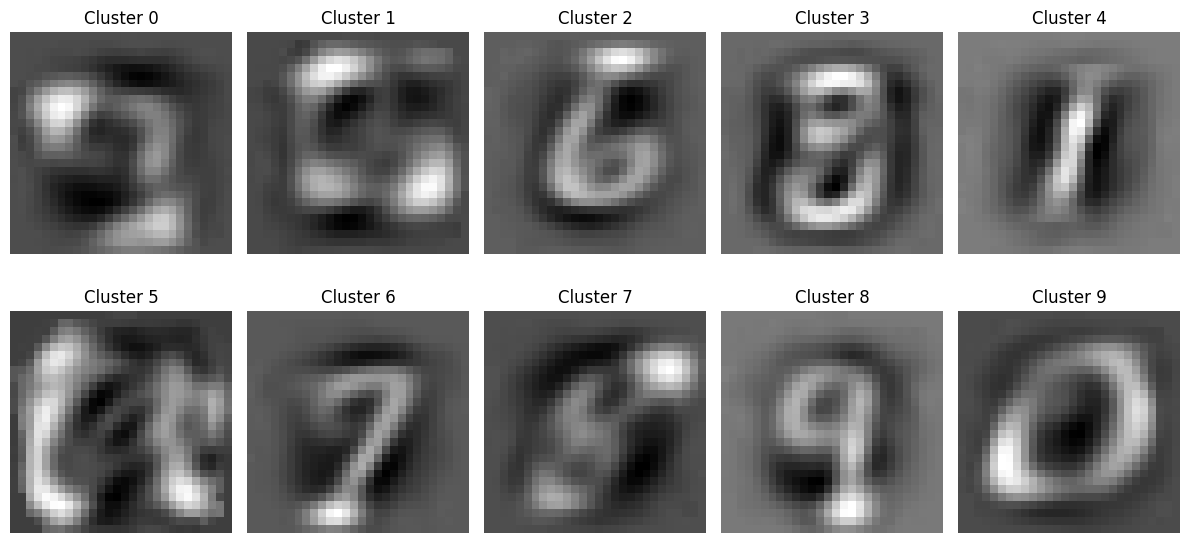

In [30]:
visualize_cluster_means(gmm_best, best_pca)

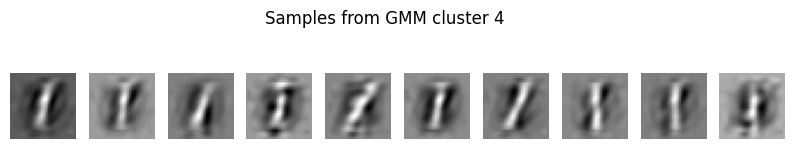

In [34]:
sample_from_cluster(gmm_best, best_pca, cluster_id=4)

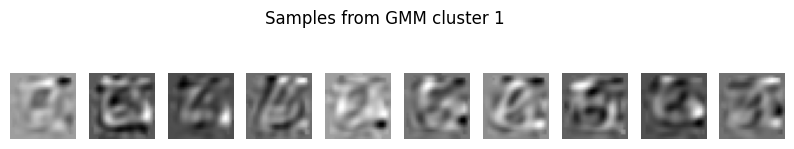

In [35]:
sample_from_cluster(gmm_best, best_pca, cluster_id=1)

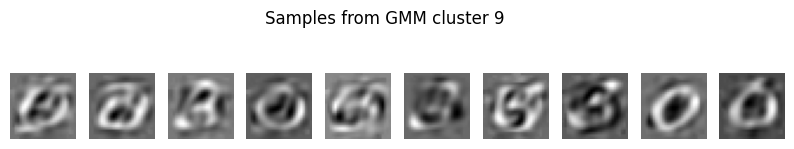

In [36]:
sample_from_cluster(gmm_best, best_pca, cluster_id=9)

# Discussion
## Results:
The results from applying grid search to find the best hyperparameters for the sklearn GMM function on the MNIST dataset show that the optimal hyperparameters are:
- PCA dimension: 50
- Number of components: 10
- Covariance type: full
- Number of initializations: 20

The best model was selected according to the lowest Bayesian Information Criterion (BIC). As GMM is computationally expensive and time consuming, the hyperparameter grid search was performed on a subset of the full dataset, containing 2000 data points instead of the complete 60,000. Using these hyperparameters, the model was then fit on the full training set to give the final scores:
- Log-likelihood: -822,498.96
- BIC: 1,790,874.76
- AIC: 1,671,515.92
These scores grow with the dataset as they are not normalized per sample. The reason why the scores were sorted based on BIC is because it penalizes model complexity more strongly and it prefers models that perform better generalization whereas AIC does not penalize complex models as much and tends to prefer larger and more overfitted models. The log-likelihood is proportional to the number of components and the covariance matrices, which means that is always prefers bigger and more complex models.

## Interpreting the Clusters:
From visualizing the cluster means we can see that the clusters do resemble number digits such as cluster 2 resembles '6', cluster 8 resembles '9' and cluster 6 resembles '7'. Some of the other clusters are more ambiguous such as clusters 1 and 5 which are unclear on which digit they represent. From sampling some of the clusters, we can see that cluster 4 looks like it represents '1'. Whereas cluster 9 somewhat resembles '0' in some of the samples and cluster 1 kind of looks like a mixture of different numbers. But it does still maintain some characteristics of number which shows that the GMM model was able to learn meaningful features and PCA-whitened space is able to preserve digit geometry to a certain extent.

Overall, each cluster responds to a Gaussian region in the PCA space that represents different features such as different numbers, different writing styles and other variations between the same number and different numbers. Since there are only 10 components in the best model, these different features are compressed together which can result in some clusters not resembling any particular digit. For example, some variations of '4' can look like a '9' and the model might cluster them together.

## EM Behavior:
Increasing n_components increases model flexibility as more clusters can be made resulting in more nuanced clusters. This also increases the log-likelihood, but it also increases model complexity which means that it will be penalized by the BIC score as the number of parameters explode in full covariance matrices. Furthermore, with more clusters, mixing weights have a greater risk of collapsing the EM has a greater chance of getting stuck in a local minima, and the algorithm becomes more sensitive to initializations.  

